# Adding a function calculating view confidence to the BL model

In [15]:
#importing packages and data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.integrate as integrate

In [16]:
#data on our stocks of choice (as a pandas dataframe)

tickers = ['AMZN','AAPL','BRK-A','XOM','MSFT','TSLA','UNH']
data = yf.download(tickers, start="2017-11-14",end="2022-11-14")
prices = data['Adj Close']
prices.tail()

[*********************100%***********************]  7 of 7 completed


,AAPL,AMZN,BRK-A,MSFT,TSLA,UNH,XOM
Date,,,,,,,
2022-11-07,138.919998,90.529999,438575.0,227.229630,197.080002,545.020020,112.732475
2022-11-08,139.500000,89.980003,442100.0,228.226822,191.300003,553.049988,113.089600
2022-11-09,134.869995,86.139999,435945.0,223.879074,177.589996,540.659973,108.030334
2022-11-10,146.869995,96.629997,457665.0,242.297165,190.720001,544.169983,109.617554
2022-11-11,149.699997,100.790001,469047.0,246.415558,195.970001,522.080017,113.040001


In [3]:
#data on the market (as a pandas series)

market_prices = yf.download("SPY", start="2017-11-14", end="2022-11-14")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
2017-11-14    236.508209
2017-11-15    235.324371
2017-11-16    237.324890
2017-11-17    236.627472
2017-11-20    237.031219
Name: Adj Close, dtype: float64

In [5]:
#a dictionary of market caps
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info['marketCap']
mcaps

{'AMZN': 960796164096,
 'AAPL': 2313514909696,
 'BRK-A': 696700698624,
 'XOM': 455647592448,
 'MSFT': 1813449015296,
 'TSLA': 583659552768,
 'UNH': 501591277568}

In [6]:
import pypfopt

In [9]:
#market implied risk premium and variance-covariance matrix

from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
print(delta)
S

2.354382221980938


,AAPL,AMZN,BRK-A,MSFT,TSLA,UNH,XOM
AAPL,0.110720,0.075439,0.040538,0.077575,0.098872,0.047699,0.037758
AMZN,0.075439,0.126363,0.031366,0.076801,0.097810,0.036003,0.025849
BRK-A,0.040538,0.031366,0.051274,0.038923,0.040998,0.037809,0.044619
MSFT,0.077575,0.076801,0.038923,0.095648,0.091127,0.049349,0.034742
TSLA,0.098872,0.097810,0.040998,0.091127,0.413354,0.044131,0.043251
UNH,0.047699,0.036003,0.037809,0.049349,0.044131,0.089028,0.040311
XOM,0.037758,0.025849,0.044619,0.034742,0.043251,0.040311,0.113783


In [10]:
#prior: market implied returns

market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL     0.211681
AMZN     0.194839
BRK-A    0.114317
MSFT     0.196000
TSLA     0.277004
UNH      0.132348
XOM      0.117573
dtype: float64

In [83]:
#adding our views and other analysts' views 
#(which I've made up to be different in places but not too accurate, could maybe find on Bloomberg?)
#have also assumed that investment horizons are the same for all, however adjustments can be made if not

viewdict = {
    "AAPL": 0.2,
    "AMZN": 0.3,
    "BRK-A": 0.1,
    "MSFT": 0.1,
    "TSLA": 0.2,
    "UNH": 0.1,
    "XOM": 0.6
}

other_analyst_views = [0.25,0.2,0.15,0.2,0.3,0.15,0.1]

In [101]:
def confidence_calc(n):
    
    stock = list(viewdict.keys())[n]
    mu = other_analyst_views[n]
    sigma = (S[stock][stock])**0.5
    
    def normal_pdf(x):
        output = (sigma*(2*3.1415926)**0.5)**(-1)*np.power(2.718281828,-0.5*((x-mu)/sigma)**2)
        return(output)
    
    def normal_cdf(x):
        output = integrate.quad(normal_pdf,-1*np.inf,x)
        return(output)
       
    if viewdict[stock]>other_analyst_views[n]:
        output = 2*(1-normal_cdf(viewdict[stock])[0])
    else:
        output = 2*normal_cdf(viewdict[stock])[0]
    return(output)
    
confidences = [confidence_calc(n) for n in range(len(viewdict))]

confidences

[0.8805557254805658,
 0.7784702531610617,
 0.8252395326118637,
 0.7464369127102517,
 0.8763965810802893,
 0.8669185886952699,
 0.13826520132824927]

In [90]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

In [91]:
np.diag(bl.omega)

#lots of variation, good

array([0.00075094, 0.00179796, 0.00054291, 0.00162458, 0.00291489,
       0.00068334, 0.03545757])

In [93]:
omega = bl.omega
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)
ret_bl = bl.bl_returns()
ret_bl

AAPL     0.197622
AMZN     0.246512
BRK-A    0.100490
MSFT     0.150294
TSLA     0.212087
UNH      0.101603
XOM      0.145446
dtype: float64

In [95]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.211681,0.197622,0.2
AMZN,0.194839,0.246512,0.3
BRK-A,0.114317,0.100490,0.1
MSFT,0.196000,0.150294,0.1
TSLA,0.277004,0.212087,0.2
UNH,0.132348,0.101603,0.1
XOM,0.117573,0.145446,0.6


<AxesSubplot:>

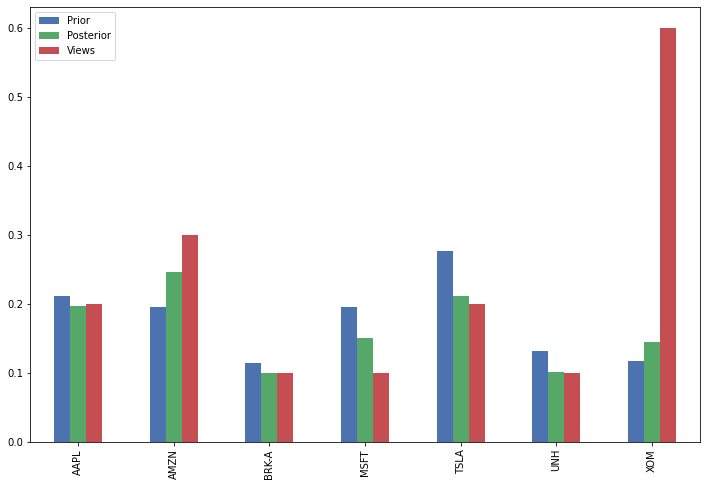

In [97]:
#final expected returns, alongside the market implied prior and the views

rets_df.plot.bar(figsize=(12,8))

More conservative (and diversified) than my earlier simulation. Previously, views were only punished for disagreeing with market implied returns, but now they are also punished for disagreeing with other analysts' predictions.

In [98]:
#portfolio allocation:

from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

C:\Users\samdo\anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.18444),
             ('AMZN', 0.25317),
             ('BRK-A', 0.07863),
             ('MSFT', 0.12029),
             ('TSLA', 0.15215),
             ('UNH', 0.0739),
             ('XOM', 0.13741)])

<AxesSubplot:ylabel='None'>

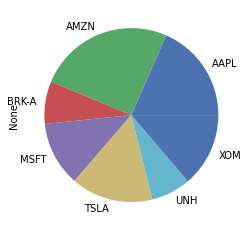

In [99]:
pd.Series(weights).plot.pie()

In [100]:
#hypothetical allocation of $15000

from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=15000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $1319.95


C:\Users\samdo\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'AAPL': 18, 'AMZN': 38, 'MSFT': 7, 'TSLA': 12, 'UNH': 2, 'XOM': 18}